In [13]:
# Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.

# Absolute camera orientation given set of relative camera pairs

This tutorial showcases the `cameras`, `transforms` and `so3` API.

The problem we deal with is defined as follows:

Given an optical system of $N$ cameras with extrinsics $\{g_1, ..., g_N | g_i \in SE(3)\}$, and a set of relative camera positions $\{g_{ij} | g_{ij}\in SE(3)\}$ that map between coordinate frames of randomly selected pairs of cameras $(i, j)$, we search for the absolute extrinsic parameters $\{g_1, ..., g_N\}$ that are consistent with the relative camera motions.

More formally:
$$
g_1, ..., g_N = 
{\arg \min}_{g_1, ..., g_N} \sum_{g_{ij}} d(g_{ij}, g_i^{-1} g_j),
$$,
where $d(g_i, g_j)$ is a suitable metric that compares the extrinsics of cameras $g_i$ and $g_j$. 

Visually, the problem can be described as follows. The picture below depicts the situation at the beginning of our optimization. The ground truth cameras are plotted in green while the randomly initialized estimated cameras are plotted in blue:
![Initialization](./data/bundle_adjustment_initialization.png)

Our optimization seeks to align the estimated (blue) cameras with the ground truth (green) cameras, by minimizing the discrepancies between pairs of relative cameras. Thus, the solution to the problem should look as follows:
![Solution](./data/bundle_adjustment_final.png)

In practice, the camera extrinsics $g_{ij}$ and $g_i$ are represented using objects from the `SfMPerspectiveCameras` class initialized with the corresponding rotation and translation matrices `R_absolute` and `T_absolute` that define the extrinsic parameters $g = (R, T); R \in SO(3); T \in \mathbb{R}^3$. In order to ensure that `R_absolute` is a valid rotation matrix, we represent it using an exponential map (implemented with `so3_exponential_map`) of the axis-angle representation of the rotation `log_R_absolute`.

Note that the solution to this problem could only be recovered up to an unknown global rigid transformation $g_{glob} \in SE(3)$. Thus, for simplicity, we assume knowledge of the absolute extrinsics of the first camera $g_0$. We set $g_0$ as a trivial camera $g_0 = (I, \vec{0})$.


## 0. Import Modules

In [1]:
# imports
import torch
from pytorch3d.transforms.so3 import (
    so3_exponential_map,
    so3_relative_angle,
)
from pytorch3d.renderer.cameras import (
    SfMPerspectiveCameras,
)

# add path for demo utils
import sys
import os
sys.path.append(os.path.abspath(''))
from utils import plot_camera_scene

# set for reproducibility
torch.manual_seed(42)

## 1. Set up Cameras and load ground truth posiitonns

In [2]:
# load the SE3 graph of relative/absolute camera positions
camera_graph_file = './data/camera_graph.pth'
(R_absolute_gt, T_absolute_gt), \
    (R_relative, T_relative), \
    relative_edges = \
        torch.load(camera_graph_file)

# create the relative cameras
cameras_relative = SfMPerspectiveCameras(
    R = R_relative.cuda(),
    T = T_relative.cuda(),
    device = "cuda",
)

# create the absolute ground truth cameras
cameras_absolute_gt = SfMPerspectiveCameras(
    R = R_absolute_gt.cuda(),
    T = T_absolute_gt.cuda(),
    device = "cuda",
)

# the number of absolute camera positions
N = R_absolute_gt.shape[0]

## 3. Define optimization functions

### Relative cameras and camera distance
We now define two functions crucial for the optimization.

**`calc_camera_distance`** compares a pair of cameras. This function is important as it defines the loss that we are minimizing. The method utilizes the `so3_relative_angle` function from the SO3 API.

**`get_relative_camera`** computes the parameters of a relative camera that maps between a pair of absolute cameras. Here we utilize the `compose` and `inverse` class methods from the PyTorch3d Transforms API.

In [8]:
# 
def calc_camera_distance(cam_1, cam_2):
    """
    Calculates the divergence of a batch of pairs of cameras cam_1, cam_2.
    The distance is composed of the cosine of the relative angle between 
    the rotation components of the camera extrinsics and the l2 distance
    between the translation vectors.
    """
    # rotation distance
    R_distance = (1.-so3_relative_angle(cam_1.R, cam_2.R, cos_angle=True)).mean()
    # translation distance
    T_distance = ((cam_1.T - cam_2.T)**2).sum(1).mean()
    # the final distance is the sum
    return R_distance + T_distance

def get_relative_camera(cams, edges):
    """
    For each pair of indices (i,j) in "edges" generate a camera
    that maps from the coordinates of the camera cams[i] to 
    the coordinates of the camera cams[j]
    """

    # first generate the world-to-view Transform3d objects of each 
    # camera pair (i, j) according to the edges argument
    trans_i, trans_j = [
        SfMPerspectiveCameras(
            R = cams.R[edges[:, i]],
            T = cams.T[edges[:, i]],
            device = "cuda",
        ).get_world_to_view_transform()
         for i in (0, 1)
    ]
    
    # compose the relative transformation as g_i^{-1} g_j
    trans_rel = trans_i.inverse().compose(trans_j)
    
    # generate a camera from the relative transform
    matrix_rel = trans_rel.get_matrix()
    cams_relative = SfMPerspectiveCameras(
                        R = matrix_rel[:, :3, :3],
                        T = matrix_rel[:, 3, :3],
                        device = "cuda",
                    )
    return cams_relative

## 4. Optimization
Finally, we start the optimization of the absolute cameras.

We use SGD with momentum and optimize over `log_R_absolute` and `T_absolute`. 

As mentioned earlier, `log_R_absolute` is the axis angle representation of the rotation part of our absolute cameras. We can obtain the 3x3 rotation matrix `R_absolute` that corresponds to `log_R_absolute` with:

`R_absolute = so3_exponential_map(log_R_absolute)`


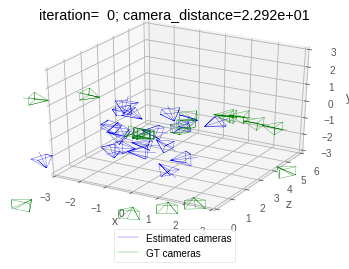

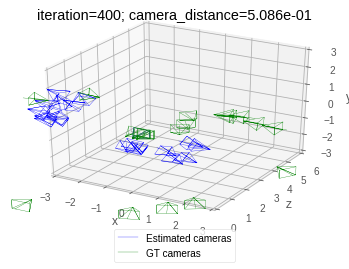

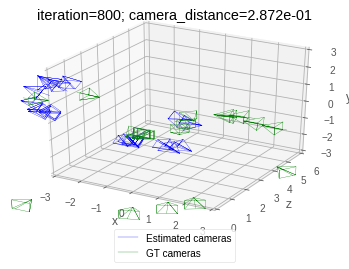

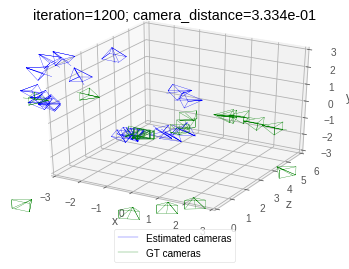

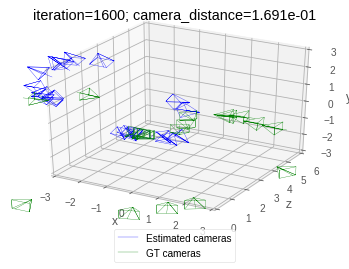

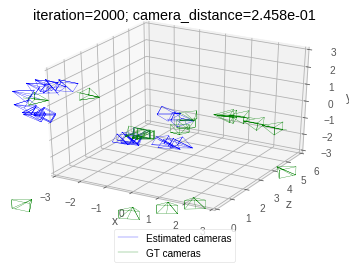

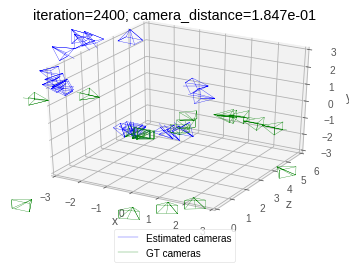

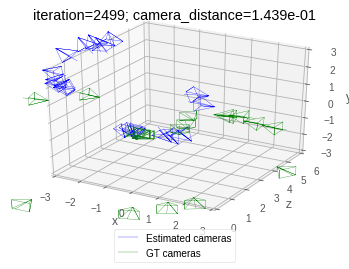

Optimization finished.


In [9]:
# initialize the absolute log-rotations/translations with random entries
log_R_absolute_init = torch.randn(N, 3).float().cuda()
T_absolute_init = torch.randn(N, 3).float().cuda()

# futhermore, we know that the first camera is a trivial one 
#    (see the description above)
log_R_absolute_init[0, :] = 0.
T_absolute_init[0, :] = 0.

# instantiate a copy of the initialization of log_R / T
log_R_absolute = log_R_absolute_init.clone().detach()
log_R_absolute.requires_grad = True
T_absolute = T_absolute_init.clone().detach()
T_absolute.requires_grad = True

# the mask the specifies which cameras are going to be optimized
#     (since we know the first camera is already correct, 
#      we only optimize over the 2nd-to-last cameras)
camera_mask = torch.ones(N, 1).float().cuda()
camera_mask[0] = 0.

# init the optimizer
optimizer = torch.optim.SGD([log_R_absolute, T_absolute], lr=.9, momentum=0.9)

# run the optimization
n_iter = 2500  # fix the number of iterations
for it in range(n_iter):
    # re-init the optimizer gradients
    optimizer.zero_grad()

    # compute the absolute camera rotations as 
    # an exponential map of the logarithms (=axis-angles)
    # of the absolute rotations
    R_absolute = so3_exponential_map(log_R_absolute * camera_mask)

    # get the current absolute cameras
    cameras_absolute = SfMPerspectiveCameras(
        R = R_absolute,
        T = T_absolute * camera_mask,
        device = "cuda",
    )

    # compute the relative cameras as a compositon of the absolute cameras
    cameras_relative_composed = \
        get_relative_camera(cameras_absolute, relative_edges)

    # compare the composed cameras with the ground truth relative cameras
    # camera_distance corresponds to $d$ from the description
    camera_distance = \
        calc_camera_distance(cameras_relative_composed, cameras_relative)

    # print status message
    if it % 400==0 or it==n_iter-1:
        status = 'iteration=%3d; camera_distance=%1.3e' % (it, camera_distance)
        plot_camera_scene(cameras_absolute, cameras_absolute_gt, status)

    # our loss function is the camera_distance
    camera_distance.backward()
    
    # apply the gradients
    optimizer.step()

print('Optimization finished.')
